In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/archive.zip archive.zip

In [3]:
!cp /content/drive/MyDrive/valset.zip valset.zip

In [4]:
!unzip archive.zip

Archive:  archive.zip
  inflating: dataset/Bus/Bus_1.jpg   
  inflating: dataset/Bus/Bus_12.jpg  
  inflating: dataset/Bus/Bus_13.jpg  
  inflating: dataset/Bus/Bus_14.jpg  
  inflating: dataset/Bus/Bus_15.jpg  
  inflating: dataset/Bus/Bus_19.jpg  
  inflating: dataset/Bus/Bus_2.jpg   
  inflating: dataset/Bus/Bus_20.jpg  
  inflating: dataset/Bus/Bus_25.jpg  
  inflating: dataset/Bus/Bus_29.jpg  
  inflating: dataset/Bus/Bus_30.JPG  
  inflating: dataset/Bus/Bus_33.jpg  
  inflating: dataset/Bus/Bus_35.JPG  
  inflating: dataset/Bus/Bus_36.jpg  
  inflating: dataset/Bus/Bus_37.jpg  
  inflating: dataset/Bus/Bus_38.jpg  
  inflating: dataset/Bus/Bus_4.jpg   
  inflating: dataset/Bus/Bus_40.jpg  
  inflating: dataset/Bus/Bus_42.jpg  
  inflating: dataset/Bus/Bus_44.jpg  
  inflating: dataset/Bus/Bus_5.jpg   
  inflating: dataset/Bus/Bus_50.jpg  
  inflating: dataset/Bus/Bus_51.jpg  
  inflating: dataset/Bus/Bus_52.jpg  
  inflating: dataset/Bus/Bus_53.jpg  
  inflating: dataset/Bus/Bus

In [5]:
!unzip valset.zip

Archive:  valset.zip
   creating: valset/
   creating: valset/Bus/
  inflating: valset/Bus/Bus_20.jpg   
  inflating: valset/Bus/Bus_25.jpg   
  inflating: valset/Bus/Bus_29.jpg   
  inflating: valset/Bus/Bus_30.JPG   
  inflating: valset/Bus/Bus_37.jpg   
  inflating: valset/Bus/Bus_38.jpg   
  inflating: valset/Bus/Bus_42.jpg   
  inflating: valset/Bus/Bus_51.jpg   
  inflating: valset/Bus/Bus_52.jpg   
  inflating: valset/Bus/Bus_53.jpg   
  inflating: valset/Bus/Bus_54.jpg   
  inflating: valset/Bus/Bus_55.jpg   
  inflating: valset/Bus/Bus_56.jpg   
  inflating: valset/Bus/Bus_57.jpg   
  inflating: valset/Bus/Bus_58.jpg   
  inflating: valset/Bus/Bus_60.jpg   
  inflating: valset/Bus/Bus_61.jpg   
  inflating: valset/Bus/Bus_63.jpg   
  inflating: valset/Bus/Bus_65.jpg   
  inflating: valset/Bus/Bus_73.jpg   
  inflating: valset/Bus/Bus_76.jpeg  
  inflating: valset/Bus/Bus_77.jpeg  
  inflating: valset/Bus/Bus_78.jpeg  
  inflating: valset/Bus/Bus_79.jpeg  
  inflating: valset/B

In [6]:
import os
Dataset = './dataset'
labels = sorted(os.listdir(Dataset))
labels

['Bus', 'Hatchback', 'Motorcycle', 'Pickup', 'Sedan', 'Truck']

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2
import imghdr
import shutil

In [8]:
image_directory = '/content/dataset'
compatible_extns = ['png', 'jpg', 'jpeg', 'JPG']

for image_class in os.listdir(image_directory):
    for image in os.listdir(os.path.join(image_directory, image_class)):
        image_path = os.path.join(image_directory, image_class, image)
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
        if tip not in compatible_extns:
            print('Image not in ext list {}'.format(image_path))
            os.remove(image_path)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.25
)

train_generator = image_datagen.flow_from_directory(
    image_directory,
    shuffle=True,
    target_size=(224, 224),
    batch_size=32,
    subset="training",
    class_mode='categorical'
)

valid_generator = image_datagen.flow_from_directory(
    image_directory,
    shuffle=False,
    target_size=(224, 224),
    batch_size=32,
    subset="validation",
    class_mode='categorical'
)

Found 678 images belonging to 6 classes.
Found 222 images belonging to 6 classes.


In [10]:
train_generator.class_indices

{'Bus': 0,
 'Hatchback': 1,
 'Motorcycle': 2,
 'Pickup': 3,
 'Sedan': 4,
 'Truck': 5}

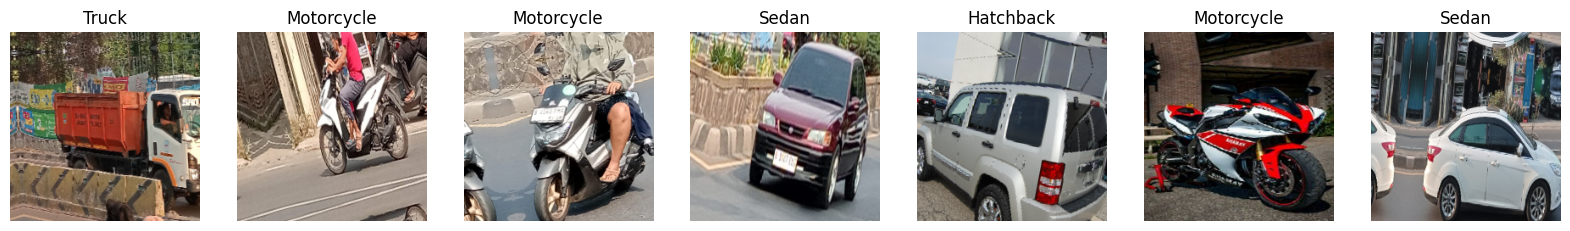

In [11]:
import numpy as np
import pandas as pd

model_dict = train_generator.class_indices
model_dict_as_list = list(model_dict.keys())
train_imgs, labels = train_generator.__next__()

fig, ax = plt.subplots(ncols = 7, figsize = (20,20))
for i_img in range (7):
    ax[i_img].imshow(train_imgs[i_img])
    ax[i_img].title.set_text(model_dict_as_list[np.argmax(labels[i_img])])
    ax[i_img].axis('off')

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, Adamax

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input

inception_model = InceptionV3(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3)  # Define input shape here
)

input_tensor = Input(shape=(224, 224, 3))  # Define input with None for batch size

# Pass the input to InceptionV3
x = inception_model(input_tensor)

for layer in inception_model.layers[:-8]:
    layer.trainable = True

car_recog_model = tf.keras.models.Sequential([
    inception_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

car_recog_model.compile(
    optimizer=Adam(learning_rate=0.00001),  # Adjust the learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

car_recog_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,110 (91.20 MB)

 Trainable params: 23,872,678 (91.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [13]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

class AccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 1) and (
                logs.get('accuracy') is not None and logs.get('accuracy') >= 1):
            self.model.stop_training = True

accuracy_callback = AccuracyCallback()

In [14]:
hist = car_recog_model.fit(
    train_generator,
    epochs=100,
    validation_data=valid_generator,
    callbacks=[tensorboard_callback, accuracy_callback]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 169s 4s/step - accuracy: 0.1962 - loss: 1.9833 - val_accuracy: 0.2973 - val_loss: 1.6980
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 800ms/step - accuracy: 0.3126 - loss: 1.7168 - val_accuracy: 0.3964 - val_loss: 1.4631
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 798ms/step - accuracy: 0.3853 - loss: 1.5530 - val_accuracy: 0.6081 - val_loss: 1.2412
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 821ms/step - accuracy: 0.4315 - loss: 1.4737 - val_accuracy: 0.6261 - val_loss: 1.1309
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 796ms/step - accuracy: 0.5541 - loss: 1.3120 - val_accuracy: 0.6577 - val_loss: 1.0323
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 853ms/step - accuracy: 0.5795 - loss: 1.1880 - val_accuracy: 0.7117 - val_loss: 0.9387
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 766ms/step - accuracy: 0.6631 - loss: 1.0305 - val_accuracy: 0.6937 - val_loss: 0.9003
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6712 - loss: 0.9496 - val_accuracy: 0.7

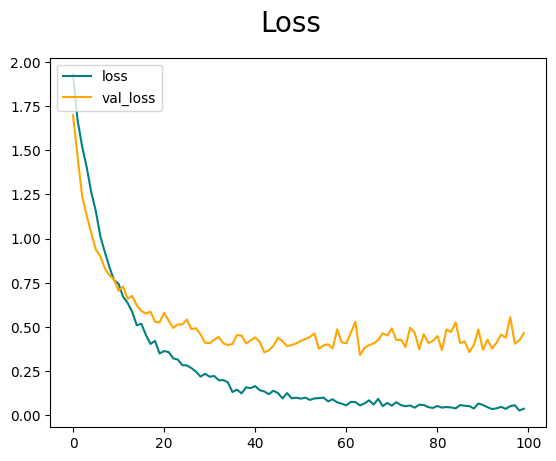

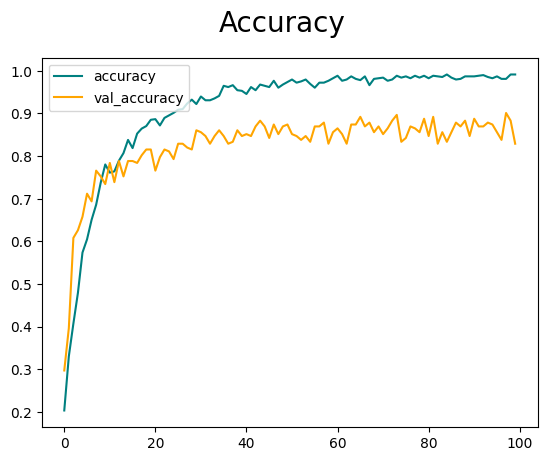

In [15]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [16]:
val_loss, val_accuracy = car_recog_model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 686ms/step - accuracy: 0.8069 - loss: 0.6799
Validation Accuracy: 83.33%


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 616ms/step
              precision    recall  f1-score   support

         Bus       0.97      0.92      0.94        37
   Hatchback       0.64      0.92      0.76        37
  Motorcycle       1.00      0.97      0.99        37
      Pickup       0.91      0.81      0.86        37
       Sedan       0.87      0.73      0.79        37
       Truck       0.91      0.84      0.87        37

    accuracy                           0.86       222
   macro avg       0.88      0.86      0.87       222
weighted avg       0.88      0.86      0.87       222



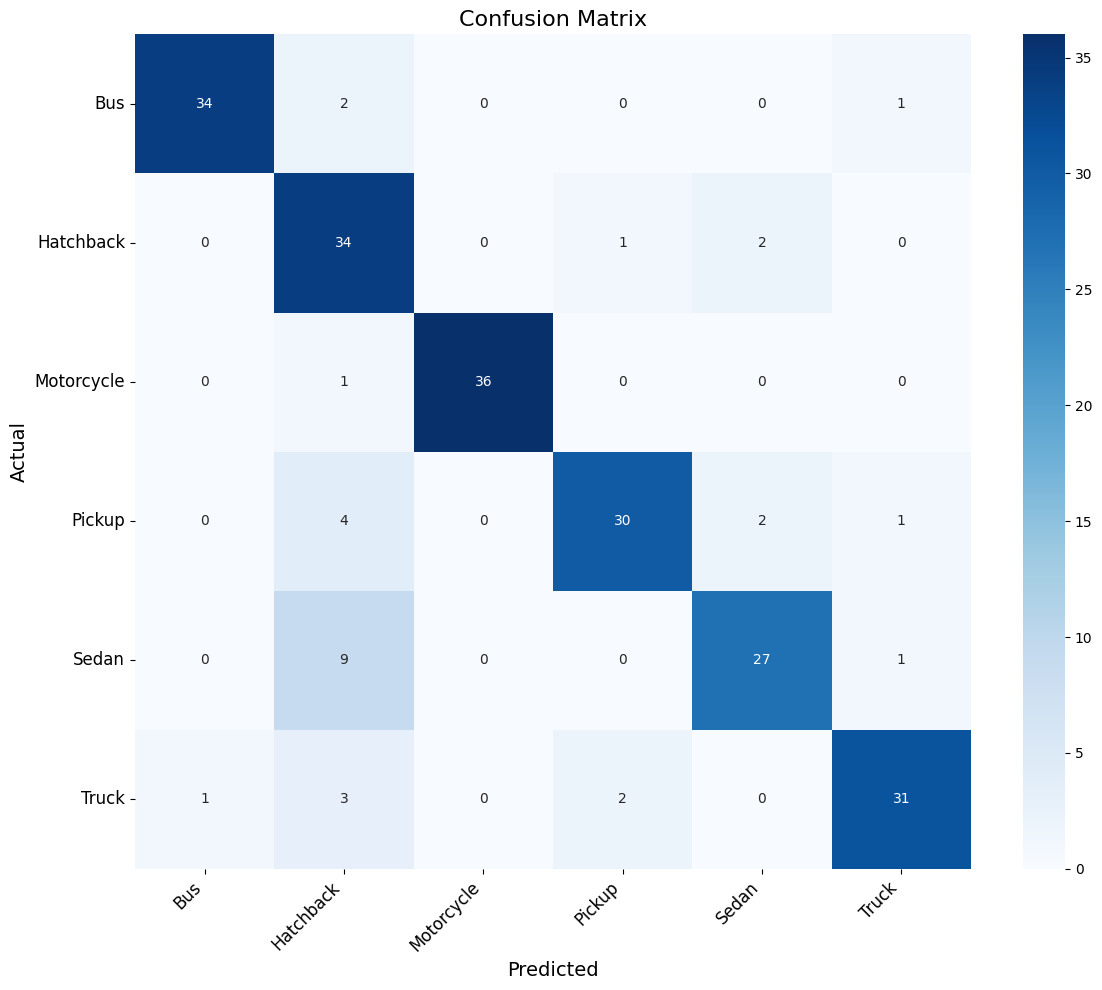

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mendapatkan label sebenarnya
true_labels = valid_generator.classes

# Mendapatkan nama kelas
class_labels = list(valid_generator.class_indices.keys())

# Mendapatkan prediksi dari model
predictions = car_recog_model.predict(valid_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Membuat laporan klasifikasi
report = classification_report(true_labels, predicted_classes, target_names=class_labels)
print(report)

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()  # Ensure the plot fits within the figure area
plt.show()

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
class_labels = list(valid_generator.class_indices.keys())
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_classes, target_names=class_labels))

Confusion Matrix:
[[34  2  0  0  0  1]
 [ 0 34  0  1  2  0]
 [ 0  1 36  0  0  0]
 [ 0  4  0 30  2  1]
 [ 0  9  0  0 27  1]
 [ 1  3  0  2  0 31]]

Classification Report:
              precision    recall  f1-score   support

         Bus       0.97      0.92      0.94        37
   Hatchback       0.64      0.92      0.76        37
  Motorcycle       1.00      0.97      0.99        37
      Pickup       0.91      0.81      0.86        37
       Sedan       0.87      0.73      0.79        37
       Truck       0.91      0.84      0.87        37

    accuracy                           0.86       222
   macro avg       0.88      0.86      0.87       222
weighted avg       0.88      0.86      0.87       222



Accuracy: 86.49%
Precision: 88.41%
Recall: 86.49%
F1-Score: 86.85%
Classification Report :
               precision    recall  f1-score   support

         Bus       0.97      0.92      0.94        37
   Hatchback       0.64      0.92      0.76        37
  Motorcycle       1.00      0.97      0.99        37
      Pickup       0.91      0.81      0.86        37
       Sedan       0.87      0.73      0.79        37
       Truck       0.91      0.84      0.87        37

    accuracy                           0.86       222
   macro avg       0.88      0.86      0.87       222
weighted avg       0.88      0.86      0.87       222



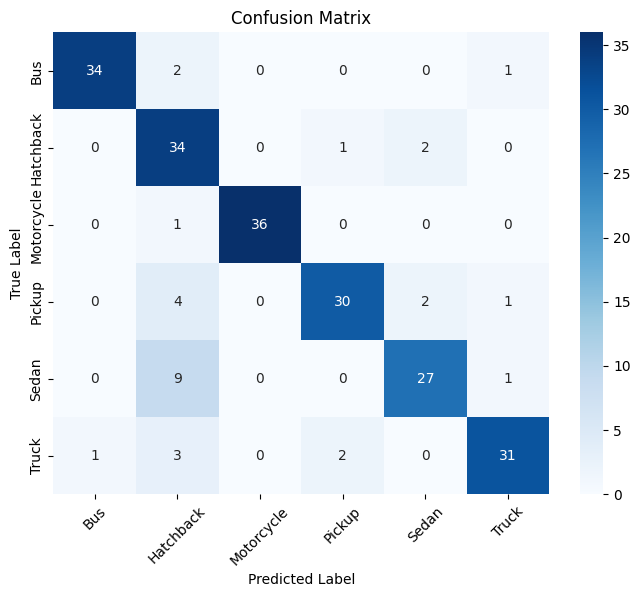

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Calculate overall metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')


print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

report = classification_report(true_labels, predicted_classes, target_names=class_labels)
print("Classification Report :\n", report)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [30]:
car_recog_model.save('/content/drive/MyDrive/1realcar_recog_incepv3.h5')
print(f'Model saved to: /content/drive/MyDrive/1realcar_recog_incepv3.h5')

Model saved to: /content/drive/MyDrive/1realcar_recog_incepv3.h5


In [31]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(car_recog_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_path = '/content/drive/MyDrive/1car_recog_incepv3.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {'/content/drive/MyDrive/1car_recog_incepv3.tflite'}")

Saved artifact at '/tmp/tmpsjyfjt9e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_313')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135754600770272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754600937632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754600927072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754600937104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754602695488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754601436736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754601432688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754601434272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754601443600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135754601443776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1357546014

/content/valset/Sedan/Sedan_16.jpg


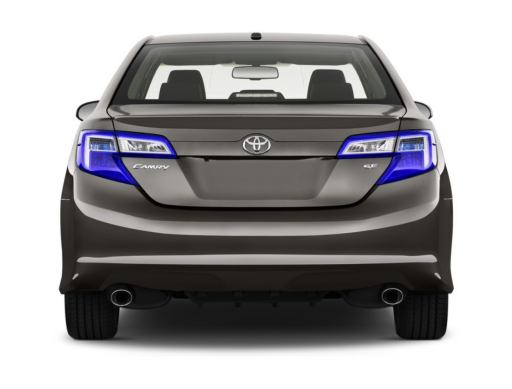

In [32]:
import cv2
import random
from PIL import Image

# Will pick random image and check
test_folders = os.listdir("/content/valset")
random_folder = random.choice(test_folders)
path = os.path.join("/content/valset", random_folder)
random_image_path = random.choice(os.listdir(os.path.join("/content/valset", random_folder)))
random_image = os.path.join("/content/valset", random_folder, random_image_path)
print(random_image)
img = cv2.imread(random_image)
plt.imshow(img)
plt.axis('off')
plt.show() # image will have weird colours because cv2 uses grb scheme.

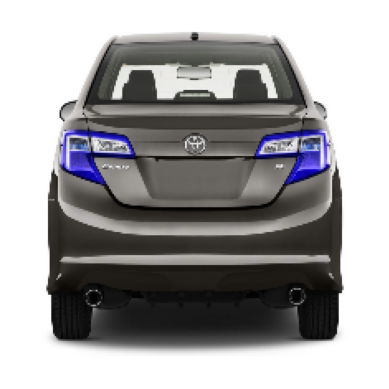

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Hatchback
[[2.0917044e-03 9.4798529e-01 5.0153822e-04 1.0734491e-02 3.8365662e-02
  3.2136301e-04]]


In [33]:
resize_img = tf.image.resize(img, (224,224))
plt.imshow(resize_img.numpy().astype(int))
plt.axis('off')
plt.show()
model_prediction = car_recog_model.predict(np.expand_dims(resize_img/255, 0))
prediction = np.argmax(model_prediction)

class_names = train_generator.class_indices

for class_label, class_index in class_names.items():
    if class_index == prediction:
        predicted_class_name = class_label

print(predicted_class_name)
print(model_prediction)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 721ms/step
Accuracy: 85.14%
Precision: 86.64%
Recall: 85.14%
F1-Score: 85.51%
Classification Report :
               precision    recall  f1-score   support

         Bus       0.97      0.86      0.91        37
   Hatchback       0.63      0.84      0.72        37
  Motorcycle       1.00      1.00      1.00        37
      Pickup       0.86      0.84      0.85        37
       Sedan       0.83      0.78      0.81        37
       Truck       0.91      0.78      0.84        37

    accuracy                           0.85       222
   macro avg       0.87      0.85      0.86       222
weighted avg       0.87      0.85      0.86       222



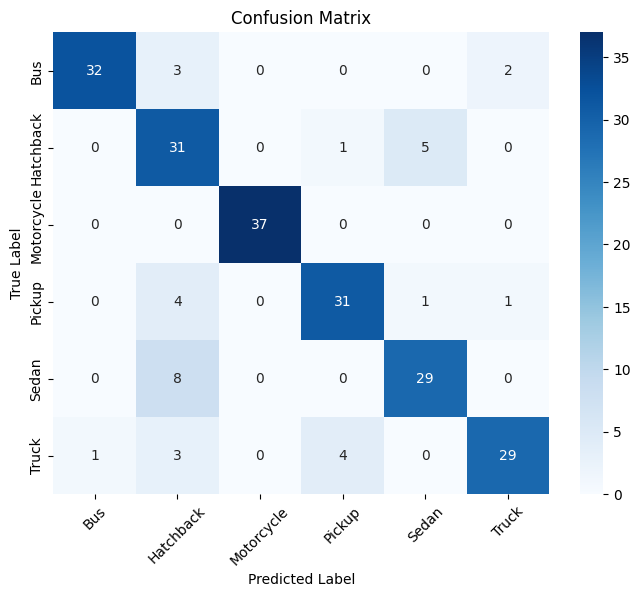

In [34]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Mendapatkan label sebenarnya
true_labels = valid_generator.classes

# Mendapatkan nama kelas
class_labels = list(valid_generator.class_indices.keys())

# Mendapatkan prediksi dari model
predictions = car_recog_model.predict(valid_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Menghitung metrik keseluruhan
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Membuat laporan klasifikasi
report = classification_report(true_labels, predicted_classes, target_names=class_labels)
print("Classification Report :\n", report)

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step
              precision    recall  f1-score   support

         Bus       0.97      0.92      0.94        37
   Hatchback       0.64      0.86      0.74        37
  Motorcycle       1.00      1.00      1.00        37
      Pickup       0.91      0.81      0.86        37
       Sedan       0.82      0.76      0.79        37
       Truck       0.91      0.81      0.86        37

    accuracy                           0.86       222
   macro avg       0.88      0.86      0.86       222
weighted avg       0.88      0.86      0.86       222



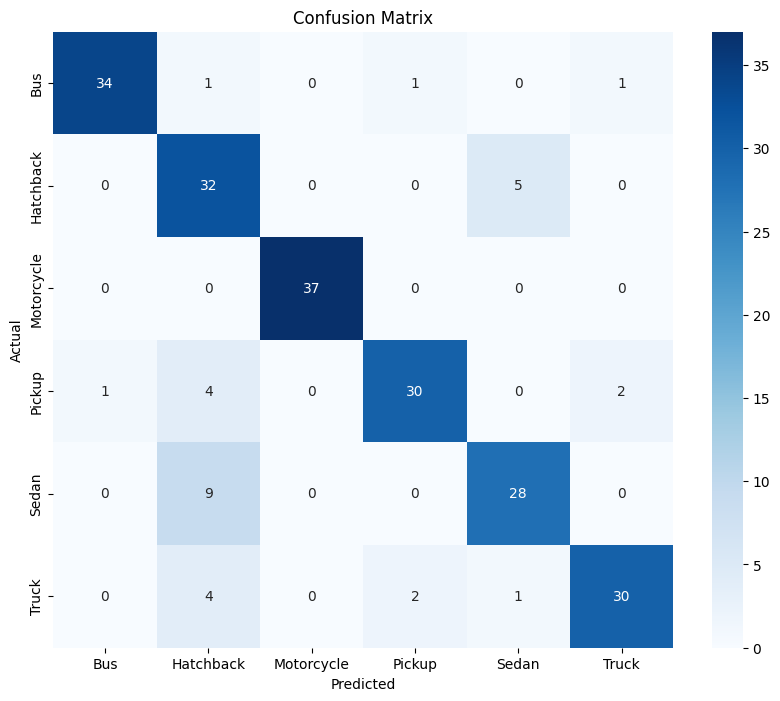

In [35]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Mengambil label kelas dari generator validasi
valid_generator.reset()
valid_labels = valid_generator.classes

# Mendapatkan prediksi dari model
predictions = car_recog_model.predict(valid_generator, steps=len(valid_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Membuat classification report
report = classification_report(valid_labels, predicted_classes, target_names=list(valid_generator.class_indices.keys()))
print(report)

# Membuat confusion matrix
conf_matrix = confusion_matrix(valid_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(valid_generator.class_indices.keys()), yticklabels=list(valid_generator.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
